In [2]:
#importing the dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dropout,LSTM,Dense
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [3]:
df = pd.read_csv("GE.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-01-02,0.776242,0.777494,0.766226,0.767478,0.159365,2316288
1,1970-01-05,0.767478,0.771234,0.757462,0.763722,0.158585,4233216
2,1970-01-06,0.762470,0.762470,0.737430,0.741186,0.153906,3544320
3,1970-01-07,0.743690,0.754958,0.743690,0.744942,0.154685,4602624
4,1970-01-08,0.747446,0.758714,0.747446,0.751202,0.155985,13897728
...,...,...,...,...,...,...,...
12818,2020-10-23,7.930000,8.030000,7.560000,7.630000,7.617370,132563200
12819,2020-10-26,7.460000,7.560000,7.280000,7.380000,7.367784,104254400
12820,2020-10-27,7.400000,7.400000,7.090000,7.100000,7.088247,98170000
12821,2020-10-28,7.510000,7.860000,7.410000,7.420000,7.407717,253494100


### SEperating dates for future plotiing

In [4]:
train_dates = pd.to_datetime(df['Date'])
train_dates

0       1970-01-02
1       1970-01-05
2       1970-01-06
3       1970-01-07
4       1970-01-08
           ...    
12818   2020-10-23
12819   2020-10-26
12820   2020-10-27
12821   2020-10-28
12822   2020-10-29
Name: Date, Length: 12823, dtype: datetime64[ns]

In [5]:
# variables for training
# we'll take all the varibales except date and volume
cols = list(df)[1:6]
cols

# Alternatively
# k = df.iloc[:,[1,2,3,4,5]]
# k

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [6]:
# Taking all the rows
df_for_training = df[cols].astype(float)
df_for_training

,Open,High,Low,Close,Adj Close
0,0.776242,0.777494,0.766226,0.767478,0.159365
1,0.767478,0.771234,0.757462,0.763722,0.158585
2,0.762470,0.762470,0.737430,0.741186,0.153906
3,0.743690,0.754958,0.743690,0.744942,0.154685
4,0.747446,0.758714,0.747446,0.751202,0.155985
...,...,...,...,...,...
12818,7.930000,8.030000,7.560000,7.630000,7.617370
12819,7.460000,7.560000,7.280000,7.380000,7.367784
12820,7.400000,7.400000,7.090000,7.100000,7.088247
12821,7.510000,7.860000,7.410000,7.420000,7.407717


<AxesSubplot:>

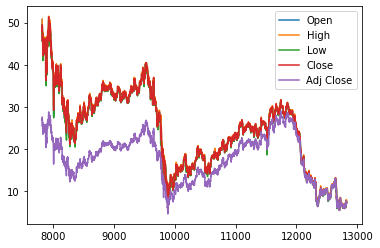

In [7]:
#Plotting the dataframe
df_for_plot = df_for_training.tail(5000)
df_for_plot.plot()


<AxesSubplot:>

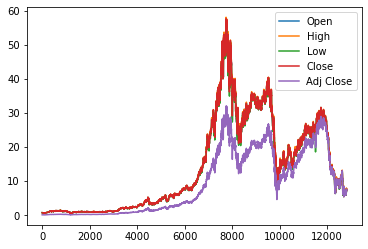

In [8]:
df_for_training.plot()

#### LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
## normalize the dataset

In [9]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaler = sc.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training) 
# Perform standardization by centering and scaling

In [10]:
print("df_for_training_scaled value is\n",df_for_training_scaled)

df_for_training_scaled value is
 [[-0.97378877 -0.97388589 -0.97415185 -0.97420562 -0.97631221]
 [-0.97443889 -0.97434522 -0.9748095  -0.97448422 -0.97639712]
 [-0.97481038 -0.97498828 -0.9763127  -0.97615581 -0.97690647]
 ...
 [-0.4824379  -0.48795858 -0.49961686 -0.5044953  -0.2220384 ]
 [-0.47427809 -0.45420602 -0.47560411 -0.48075953 -0.1872611 ]
 [-0.46315108 -0.46301104 -0.48310809 -0.48446824 -0.19269503]]


#### As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
##### In this example, the n_features is 2. We will make timesteps = 3. 
##### With this, the resultant n_samples is 5 (as the input data has 9 rows).

In [11]:
X_train = []
y_train = []

n_future = 1 # values between 1-14 and 15 willbe label
n_past = 14 #

#value between 1 to 14 will be considered as X_train and next value will be label
# this is time step

for i in range(n_past,len(df_for_training_scaled)-n_future + 1):
    X_train.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    y_train.append(df_for_training_scaled[i + n_future - 1: i+n_future,0])
    
X_train,y_train = np.array(X_train),np.array(y_train)

In [12]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
print("X_train is\n", X_train)
print("y_train is\n",y_train)



X_train is
 [[[-0.97378877 -0.97388589 -0.97415185 -0.97420562 -0.97631221]
  [-0.97443889 -0.97434522 -0.9748095  -0.97448422 -0.97639712]
  [-0.97481038 -0.97498828 -0.9763127  -0.97615581 -0.97690647]
  ...
  [-0.97611061 -0.97609067 -0.97678245 -0.97689874 -0.9771329 ]
  [-0.97713222 -0.97700933 -0.97697035 -0.97671301 -0.97707629]
  [-0.97694647 -0.97609067 -0.97659455 -0.97615581 -0.97690647]]

 [[-0.97443889 -0.97434522 -0.9748095  -0.97448422 -0.97639712]
  [-0.97481038 -0.97498828 -0.9763127  -0.97615581 -0.97690647]
  [-0.97620348 -0.97553948 -0.97584295 -0.97587721 -0.97682167]
  ...
  [-0.97713222 -0.97700933 -0.97697035 -0.97671301 -0.97707629]
  [-0.97694647 -0.97609067 -0.97659455 -0.97615581 -0.97690647]
  [-0.97638923 -0.97618254 -0.97621875 -0.97606295 -0.97687817]]

 [[-0.97481038 -0.97498828 -0.9763127  -0.97615581 -0.97690647]
  [-0.97620348 -0.97553948 -0.97584295 -0.97587721 -0.97682167]
  [-0.97592486 -0.97526388 -0.9755611  -0.97541288 -0.97668015]
  ...
  [-0.

In [13]:
print('X_train shape is :\n',X_train.shape) #12809 is number of rows 14 is timesteps and 5 is columns
print('y_train shape is :\n',y_train.shape)
print("df_for_training_scaled shape is\n",df_for_training_scaled.shape)

X_train shape is :
 (12809, 14, 5)
y_train shape is :
 (12809, 1)
df_for_training_scaled shape is
 (12823, 5)


In [14]:
#Define AutoEncoder Model
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________


In [15]:
#Fitting the model
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint('GE_STOCKS.h5',
                            monitor = 'val_loss', #Only saving the model which has minimum val loss with patience of 3
                            mode = 'min',
                            save_best_only=True,
                            verbose = 1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop,checkpoint]

# model = model.fit(X_train,y_train,epochs=100,batch_size=32,validation_split=0.1,verbose=1,earlystop)


In [22]:
from keras.models import load_model
model = load_model("GE_STOCKS.h5")

In [25]:
# plt.plot(history.history['loss'], label='Training loss')
# plt.plot(history.history['val_loss'], label='Validation loss')
# plt.legend()

### PREDICTING THE FUTUTRE

In [95]:
# Start with the last day in training date and predict future...
k_future = 90 #Predicting 90 days  in future. 
forecast_period_dates = pd.date_range(list(train_dates)[-1],periods=k_future,freq='1d').tolist()
""" Take the current date "list(train_dates)" - 1, then go to 90 days in future with a frequency of 1 day
#date_range - Return a fixed frequency DatetimeIndex.
# to list - Converts series into List."""

forecast = model.predict(X_train[-k_future:])
f"forecast shape is {forecast.shape}"


'forecast shape is (90, 1)'

In [96]:
forecast_period_dates

[Timestamp('2020-10-29 00:00:00', freq='D'),
 Timestamp('2020-10-30 00:00:00', freq='D'),
 Timestamp('2020-10-31 00:00:00', freq='D'),
 Timestamp('2020-11-01 00:00:00', freq='D'),
 Timestamp('2020-11-02 00:00:00', freq='D'),
 Timestamp('2020-11-03 00:00:00', freq='D'),
 Timestamp('2020-11-04 00:00:00', freq='D'),
 Timestamp('2020-11-05 00:00:00', freq='D'),
 Timestamp('2020-11-06 00:00:00', freq='D'),
 Timestamp('2020-11-07 00:00:00', freq='D'),
 Timestamp('2020-11-08 00:00:00', freq='D'),
 Timestamp('2020-11-09 00:00:00', freq='D'),
 Timestamp('2020-11-10 00:00:00', freq='D'),
 Timestamp('2020-11-11 00:00:00', freq='D'),
 Timestamp('2020-11-12 00:00:00', freq='D'),
 Timestamp('2020-11-13 00:00:00', freq='D'),
 Timestamp('2020-11-14 00:00:00', freq='D'),
 Timestamp('2020-11-15 00:00:00', freq='D'),
 Timestamp('2020-11-16 00:00:00', freq='D'),
 Timestamp('2020-11-17 00:00:00', freq='D'),
 Timestamp('2020-11-18 00:00:00', freq='D'),
 Timestamp('2020-11-19 00:00:00', freq='D'),
 Timestamp

#### forecast

In [75]:
print("X_train[-k_future]\n",X_train[-k_future])
print("X_train[k_future]\n",X_train[k_future])

print("DIFFERENCE VALUE IS:",X_train[k_future]-X_train[-k_future])

X_train[-k_future]
 [[-0.4891141  -0.46227728 -0.49361367 -0.45702376 -0.15512897]
 [-0.40454882 -0.40284342 -0.44408737 -0.44663936 -0.13996181]
 [-0.42161024 -0.40210967 -0.42307622 -0.40361827 -0.077126  ]
 [-0.42383564 -0.42852472 -0.43883458 -0.43625496 -0.12479454]
 [-0.44015525 -0.445401   -0.46734972 -0.46666642 -0.16921276]
 [-0.50765912 -0.49162734 -0.51837682 -0.51562145 -0.24071552]
 [-0.4868887  -0.48575733 -0.50036725 -0.49336916 -0.20821424]
 [-0.51581893 -0.49162734 -0.51762642 -0.4941109  -0.20929772]
 [-0.45795847 -0.46301104 -0.48460889 -0.47705082 -0.18438013]
 [-0.47501989 -0.47841982 -0.49136247 -0.4941109  -0.20929772]
 [-0.50246652 -0.49382859 -0.50486964 -0.49114393 -0.20496414]
 [-0.4809543  -0.48428983 -0.49961686 -0.50078659 -0.21904804]
 [-0.49949932 -0.50410111 -0.50937203 -0.50894576 -0.23096509]
 [-0.50543372 -0.50776987 -0.50862164 -0.51191273 -0.23529867]]
X_train[k_future]
 [[-0.98001129 -0.98013276 -0.98054044 -0.98024193 -0.97800998]
 [-0.98056853 -

#### Perform inverse transformation to rescale back to original range
#### Since we used 5 variables for transform, the inverse expects same dimensions
#### Therefore, let us copy our values 5 times and discard them after inverse transform

In [87]:
forecast_copies = np.repeat(forecast,df_for_training.shape[1],axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [91]:
print(y_pred_future.shape)
y_pred_future

(90,)


array([7.5168533, 7.4202237, 7.309417 , 7.1969004, 7.1186604, 7.0698204,
       7.044625 , 7.0342474, 7.0465765, 7.0372334, 7.030039 , 7.006453 ,
       6.976702 , 6.960648 , 6.957299 , 7.0029907, 7.0508914, 7.095167 ,
       7.1142397, 7.1345067, 7.151471 , 7.1695485, 7.171898 , 7.1517057,
       7.135117 , 7.106697 , 7.0402017, 6.9384656, 6.831289 , 6.7299933,
       6.6606245, 6.6119485, 6.580915 , 6.5854983, 6.6285906, 6.6740465,
       6.704541 , 6.7251797, 6.7304544, 6.7259235, 6.7180223, 6.69426  ,
       6.66638  , 6.6641717, 6.676944 , 6.683237 , 6.6861463, 6.693114 ,
       6.6822805, 6.650342 , 6.6259527, 6.6105905, 6.6042314, 6.578696 ,
       6.5423403, 6.4982514, 6.445244 , 6.402287 , 6.3701744, 6.396962 ,
       6.4948125, 6.600309 , 6.6356173, 6.637796 , 6.6110587, 6.5635157,
       6.5166435, 6.489829 , 6.4648423, 6.448262 , 6.4388366, 6.4347873,
       6.448229 , 6.447175 , 6.446154 , 6.475952 , 6.560242 , 6.6466594,
       6.7124324, 6.7726727, 6.820754 , 6.9076157, 

In [93]:
f"{forecast_copies.shape}"
forecast_copies

array([[-0.47376972, -0.47376972, -0.47376972, -0.47376972, -0.47376972],
       [-0.48093772, -0.48093772, -0.48093772, -0.48093772, -0.48093772],
       [-0.48915738, -0.48915738, -0.48915738, -0.48915738, -0.48915738],
       [-0.49750388, -0.49750388, -0.49750388, -0.49750388, -0.49750388],
       [-0.5033077 , -0.5033077 , -0.5033077 , -0.5033077 , -0.5033077 ],
       [-0.50693065, -0.50693065, -0.50693065, -0.50693065, -0.50693065],
       [-0.5087997 , -0.5087997 , -0.5087997 , -0.5087997 , -0.5087997 ],
       [-0.50956947, -0.50956947, -0.50956947, -0.50956947, -0.50956947],
       [-0.5086549 , -0.5086549 , -0.5086549 , -0.5086549 , -0.5086549 ],
       [-0.509348  , -0.509348  , -0.509348  , -0.509348  , -0.509348  ],
       [-0.5098817 , -0.5098817 , -0.5098817 , -0.5098817 , -0.5098817 ],
       [-0.51163125, -0.51163125, -0.51163125, -0.51163125, -0.51163125],
       [-0.5138382 , -0.5138382 , -0.5138382 , -0.5138382 , -0.5138382 ],
       [-0.5150291 , -0.5150291 , -0.5

## CONVERTING TIMESTEPS TO DATE
## Plotting on the basis of time and date, Training completed on 5 parameters

In [104]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
# Prediction dataset
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates),'Open':y_pred_future})
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

df_forecast

,Date,Open
0,2020-10-29,7.516853
1,2020-10-30,7.420224
2,2020-10-31,7.309417
3,2020-11-01,7.196900
4,2020-11-02,7.118660
...,...,...
85,2021-01-22,7.320691
86,2021-01-23,7.437821
87,2021-01-24,7.506438
88,2021-01-25,7.529001


In [105]:
# ALL the previous dataset
original = df[['Date','Open']]
original['Date'] = pd.to_datetime(original['Date'])
original

<ipython-input-105-82323513820f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date'] = pd.to_datetime(original['Date'])


,Date,Open
0,1970-01-02,0.776242
1,1970-01-05,0.767478
2,1970-01-06,0.762470
3,1970-01-07,0.743690
4,1970-01-08,0.747446
...,...,...
12818,2020-10-23,7.930000
12819,2020-10-26,7.460000
12820,2020-10-27,7.400000
12821,2020-10-28,7.510000


In [108]:
# Considering date after 20202-5-1. SInce using large date value makes our prediction set look tiny in our graph
original = original.loc[original['Date']>='2020-5-1']
original

,Date,Open
12696,2020-05-01,6.67
12697,2020-05-04,6.30
12698,2020-05-05,6.28
12699,2020-05-06,6.20
12700,2020-05-07,6.06
...,...,...
12818,2020-10-23,7.93
12819,2020-10-26,7.46
12820,2020-10-27,7.40
12821,2020-10-28,7.51


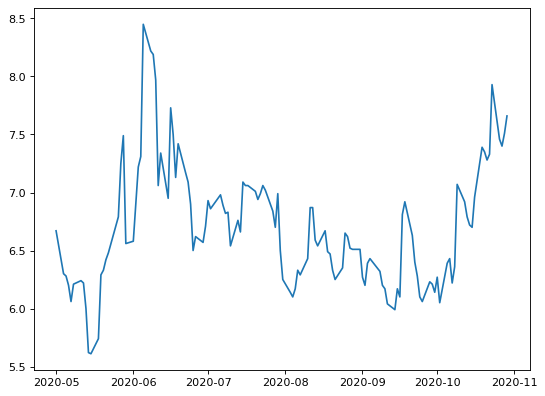

In [115]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(original['Date'],original['Open'])

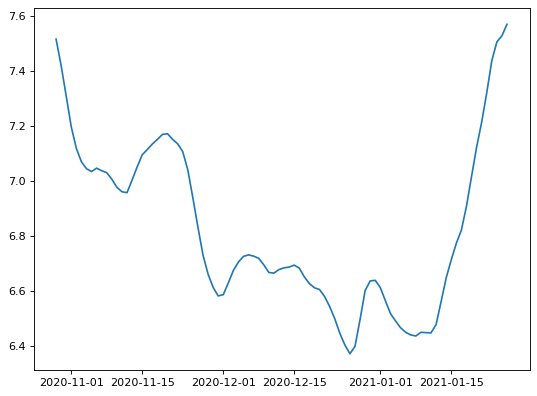

In [114]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)
plt.plot(df_forecast['Date'], df_forecast['Open'])


In [ ]:
! git add MULTIVARIATE(GE_STOCK).ipynb Multivariate.h5 GE_STOCKS.h5
! git commit -m "12:33/13-05-2021 "
! git push origin main